In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math as mt
import warnings

# 한글출력
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore') 

from src import crs, PublicPredictor

In [3]:
# 1. load_excel
data_path = "data/apt_1.xlsx"
xlsx = pd.read_excel(data_path, header=None,
                     skiprows=2, engine="openpyxl")

# 2. data preprocessing
p, m = crs.utils.data_preprocessing(xlsx)

m.set_index("month", inplace=True)

# 3. data init
_month = 1

month_df = pd.DataFrame(m.loc[_month])
month_df.reset_index(inplace=True)

month_df.columns = ['name', 'usage (kWh)']

PUBLIC_PERCENTAGE = 30
APT = crs.utils.get_APT(month_df, PUBLIC_PERCENTAGE)

calc = crs.models.ManagementOffice(
        month=_month,
        households=month_df,
        APT=APT,
        contract="단일계약"
    )
apt = calc.apart

# 히스토그램 그룹화

<AxesSubplot:>

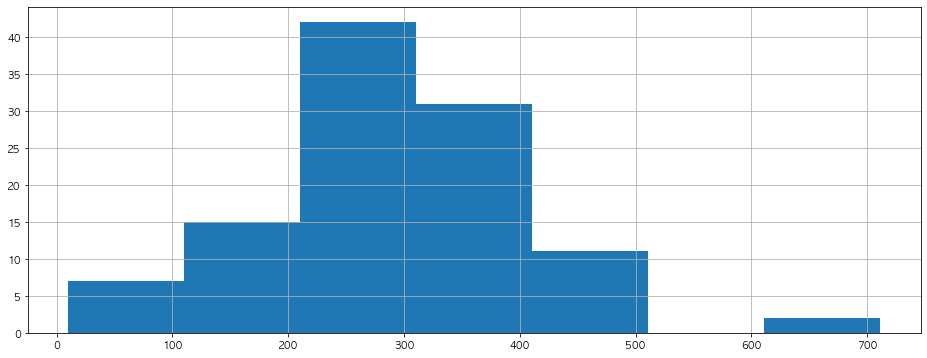

In [9]:
bins = round(mt.sqrt(len(month_df) / 2))

month_df['usage (kWh)'].hist(bins=bins, figsize=(16,6))

In [24]:
y, x = np.histogram(month_df['usage (kWh)'].values, bins=bins)
hist_df = pd.DataFrame(columns=['start', 'end', '가구 수'])

for idx, _x in enumerate(x[:-1]):
    _y = y[idx]
    
    start = _x
    end = x[idx + 1]
    
    hist_df = hist_df.append({
        "start": start,
        "end": end,
        "가구 수": _y
    }, ignore_index=True)
    
hist_df

,start,end,가구 수
0,10.000000,110.142857,7.0
1,110.142857,210.285714,15.0
2,210.285714,310.428571,42.0
3,310.428571,410.571429,31.0
4,410.571429,510.714286,11.0
5,510.714286,610.857143,0.0
6,610.857143,711.000000,2.0


In [45]:
groups = np.array([])

for usage in month_df['usage (kWh)']:
    chk = []
    
    for idx, row in hist_df.iterrows():
        start = row['start']
        end = row['end']
        
        chk.append((usage >= start) and (usage <= end))

    group_num = np.where(chk)[0][0]
    groups = np.append(groups, group_num).astype("int")
    
month_df['그룹 번호'] = groups
month_df.head(10)

,name,usage (kWh),그룹 번호
0,아파트1-101-1002,253,2
1,아파트1-101-104,689,6
2,아파트1-101-1102,183,1
3,아파트1-101-1202,239,2
4,아파트1-101-1302,455,4
5,아파트1-101-1401,343,3
6,아파트1-101-1403,380,3
7,아파트1-101-1502,219,2
8,아파트1-101-1504,389,3
9,아파트1-101-1602,350,3


# 기여도 산정

In [40]:
cont_df = month_df.copy()

In [41]:
# 방법 1. 그룹의 중간값으로 기여도 산정
# 방법 1-1. 그룹의 중간값들의 합을 통해 기여도 산정
# 방법 2-1. 중간값과 세대부 총 사용량을 비교

In [42]:
# 방법 2. 그룹안에 속해있는 가구들의 사용량 총합으로 기여도 산정

## 방법 1. 그룹의 중간값으로 기여도 산정

In [49]:
medians = []

for idx, row in hist_df.iterrows():
    start = row['start']
    end = row['end']
    
    medians.append((start + end) / 2)
    
hist_df['median'] = medians
hist_df

,start,end,가구 수,median
0,10.000000,110.142857,7.0,60.071429
1,110.142857,210.285714,15.0,160.214286
2,210.285714,310.428571,42.0,260.357143
3,310.428571,410.571429,31.0,360.500000
4,410.571429,510.714286,11.0,460.642857
5,510.714286,610.857143,0.0,560.785714
6,610.857143,711.000000,2.0,660.928571


### 방법 1-1. 그룹의 중간값들의 합을 통해 기여도 산정

In [110]:
cont_df_1_1 = month_df.copy()
cont_df_1_1['contribution'] = 0
median_total = hist_df['median'].sum()

for idx, median in enumerate(hist_df['median']):
    cont = median / median_total
    print(cont)
    cont_df_1_1['contribution'][cont_df_1_1['그룹 번호'] == idx] = cont
    
cont_df_1_1.head(10)

0.02380480624982309
0.06348891845226301
0.10317303065470294
0.14285714285714285
0.18254125505958277
0.2222253672620227
0.26190947946446264


,name,usage (kWh),그룹 번호,contribution
0,아파트1-101-1002,253,2,0.103173
1,아파트1-101-104,689,6,0.261909
2,아파트1-101-1102,183,1,0.063489
3,아파트1-101-1202,239,2,0.103173
4,아파트1-101-1302,455,4,0.182541
5,아파트1-101-1401,343,3,0.142857
6,아파트1-101-1403,380,3,0.142857
7,아파트1-101-1502,219,2,0.103173
8,아파트1-101-1504,389,3,0.142857
9,아파트1-101-1602,350,3,0.142857


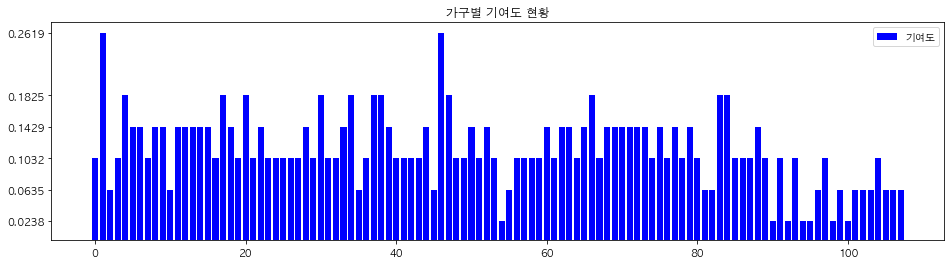

In [98]:
plt.figure(figsize=(16,4))

plt.bar(range(len(month_df)), cont_df_1_1['contribution'], color='b', label='기여도')
plt.title("가구별 기여도 현황")
plt.yticks(cont_df_1_1.groupby(by=['contribution']).count().index.values)
plt.legend()

plt.show()

### 방법 1-2. 중간값과 세대부 총 사용량을 비교

In [111]:
cont_df_1_2 = month_df.copy()
cont_df_1_2['contribution'] = 0
households_total = month_df['usage (kWh)'].sum()

for idx, median in enumerate(hist_df['median']):
    cont = median / households_total
    print(cont)
    cont_df_1_2['contribution'][cont_df_1_2['그룹 번호'] == idx] = cont
    
cont_df_1_2.head(10)

0.0019313087889476779
0.005150922251616697
0.008370535714285716
0.011590149176954733
0.01480976263962375
0.018029376102292768
0.02124898956496179


,name,usage (kWh),그룹 번호,contribution
0,아파트1-101-1002,253,2,0.008371
1,아파트1-101-104,689,6,0.021249
2,아파트1-101-1102,183,1,0.005151
3,아파트1-101-1202,239,2,0.008371
4,아파트1-101-1302,455,4,0.014810
5,아파트1-101-1401,343,3,0.011590
6,아파트1-101-1403,380,3,0.011590
7,아파트1-101-1502,219,2,0.008371
8,아파트1-101-1504,389,3,0.011590
9,아파트1-101-1602,350,3,0.011590


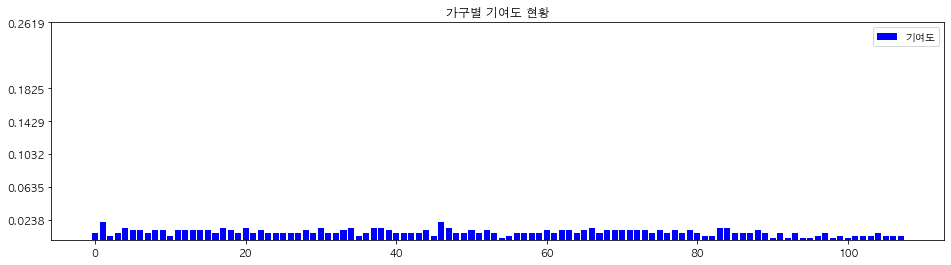

In [112]:
plt.figure(figsize=(16,4))

plt.bar(range(len(month_df)), cont_df_1_2['contribution'], color='b', label='기여도')
plt.title("가구별 기여도 현황")
plt.yticks(cont_df_1_1.groupby(by=['contribution']).count().index.values)
plt.legend()

plt.show()

## 방법 2. 그룹안에 속해있는 가구들의 사용량 총합으로 기여도 산정

In [101]:
cont_df_2 = month_df.copy()
cont_df_2['contribution'] = 0
hist_df_2 = hist_df.copy()
total_usages = []

for idx in hist_df_2.index:
    total_usage = cont_df_2[cont_df_2['그룹 번호'] == idx]['usage (kWh)'].sum()
    total_usages.append(total_usage)
    
hist_df_2['사용량 총 합'] = total_usages
hist_df_2

,start,end,가구 수,median,사용량 총 합
0,10.000000,110.142857,7.0,60.071429,315
1,110.142857,210.285714,15.0,160.214286,2551
2,210.285714,310.428571,42.0,260.357143,10768
3,310.428571,410.571429,31.0,360.500000,11154
4,410.571429,510.714286,11.0,460.642857,4916
5,510.714286,610.857143,0.0,560.785714,0
6,610.857143,711.000000,2.0,660.928571,1400


In [108]:
cont_df_2 = hist_df_2.copy()
cont_df_2['contribution'] = cont_df_2['사용량 총 합'] / households_total

cont_df_2

,start,end,가구 수,median,사용량 총 합,contribution
0,10.000000,110.142857,7.0,60.071429,315,0.010127
1,110.142857,210.285714,15.0,160.214286,2551,0.082015
2,210.285714,310.428571,42.0,260.357143,10768,0.346193
3,310.428571,410.571429,31.0,360.500000,11154,0.358603
4,410.571429,510.714286,11.0,460.642857,4916,0.158050
5,510.714286,610.857143,0.0,560.785714,0,0.000000
6,610.857143,711.000000,2.0,660.928571,1400,0.045010


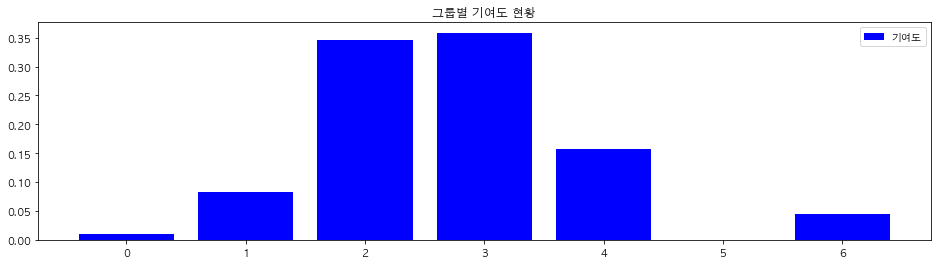

In [109]:
plt.figure(figsize=(16,4))

plt.bar(range(len(cont_df_2)), cont_df_2['contribution'], color='b', label='기여도')
plt.title("그룹별 기여도 현황")
plt.legend()

plt.show()